<a href="https://colab.research.google.com/github/bieri2/ATMS-597-Project-4-Wx-Prediction/blob/master/GroupE_Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
# Import necessary modules
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## Read in data

In [13]:
datapath = "./dataset/"

In [14]:
all_daily_data = pd.read_csv(datapath+'all_data_daily.csv', index_col = 'Timestamp')
all_3hr_data   = pd.read_csv(datapath+'all_data_3hr.csv', index_col = 'Timestamp')

In [15]:
# add week of year
DofY_daily = [pd.Period(day).dayofyear for day in all_daily_data.index.values]
all_daily_data["WofY"] = np.array(DofY_daily) // 7

### Visualize data

In [16]:
display(all_daily_data.describe(), all_3hr_data.describe())
display(all_daily_data.shape, all_3hr_data.shape)

,TMAXOBS,TMINOBS,WMAXOBS,RTOTOBS,TMAXGFS,TMINGFS,WMAXGFS,RTOTGFS,WofY
count,3626.000000,3626.000000,3628.000000,2040.000000,3613.000000,3613.000000,3613.000000,3613.000000,3651.000000
mean,16.926672,6.138230,7.672654,0.448922,15.552151,6.688519,5.833282,3.275851,25.736511
std,11.939826,10.723779,2.941521,2.894789,11.237922,10.016658,2.363949,7.164487,15.061541
min,-21.111111,-26.666667,2.235136,0.000000,-21.660000,-29.360000,1.431782,0.000000,0.000000
25%,7.222222,-1.666667,5.811354,0.000000,6.640000,-0.960000,4.045986,0.000000,13.000000
50%,18.888889,6.666667,7.152436,0.000000,17.140000,7.540000,5.456189,0.270000,26.000000
75%,27.777778,15.555556,9.387573,0.000000,25.540000,15.140000,7.244308,3.120000,39.000000
max,37.777778,25.555556,23.245418,57.600000,37.140000,25.040000,16.413714,94.690000,52.000000


,DWPC,HCLD,LCLD,MCLD,PRCP,PRES,TMPC,UWND,VWND,WSPD,...,UWND700,UWND500,UWND250,UWND100,VWND925,VWND850,VWND700,VWND500,VWND250,VWND100
count,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,...,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000,28917.000000
mean,6.784086,-30.286925,-49.801414,-57.333368,0.382154,989.433091,11.063733,0.824449,0.473716,4.171408,...,19.376416,30.859093,51.673650,32.777814,2.395426,0.559302,-1.819448,-2.970790,-1.132494,-1.266066
std,11.153594,759.245466,788.896565,820.362647,1.415245,6.705572,10.987678,2.952363,3.489771,2.111192,...,15.174755,22.000231,33.737249,20.266234,15.137554,14.362165,15.944882,22.024063,34.003168,13.731894
min,-34.820000,-9999.000000,-9999.000000,-9999.000000,0.000000,954.800000,-28.860000,-14.700000,-14.900000,0.000000,...,-48.682657,-59.107764,-111.958736,-28.931914,-50.899516,-57.491120,-66.155058,-111.739656,-129.097789,-69.065699
25%,-1.500000,0.000000,0.000000,0.000000,0.000000,985.500000,2.440000,-1.300000,-2.100000,2.657066,...,8.876137,15.097542,27.297214,17.560672,-8.352150,-8.952884,-11.965794,-15.584055,-21.475456,-10.121735
50%,7.590000,14.000000,0.000000,0.000000,0.000000,989.300000,11.940000,0.800000,0.400000,3.744329,...,19.040015,29.063532,48.684170,30.695551,1.406258,-0.254529,-2.599044,-3.483620,-2.034693,-1.912017
75%,16.430000,79.000000,37.000000,20.000000,0.070000,993.500000,20.140000,2.700000,2.900000,5.331041,...,29.545788,44.953997,73.772175,45.636246,11.976239,9.093535,7.746949,9.163638,18.116395,7.024375
max,28.600000,101.000000,101.000000,101.000000,32.750000,1016.400000,37.140000,15.500000,15.000000,16.413714,...,79.807828,118.969575,192.651946,125.579825,60.675578,74.014947,71.187446,106.871974,164.801159,65.948348


(3651, 9)

(29206, 40)

In [17]:
incomplete_daily = all_daily_data[all_daily_data.isnull().any(axis=1)]
incomplete_3hr = all_3hr_data[all_3hr_data.isnull().any(axis=1)]
display(incomplete_daily.head(), incomplete_3hr.head())
display(len(incomplete_daily), len(incomplete_3hr))

,TMAXOBS,TMINOBS,WMAXOBS,RTOTOBS,TMAXGFS,TMINGFS,WMAXGFS,RTOTGFS,WofY
Timestamp,,,,,,,,,
2010-01-05,-12.222222,-18.333333,7.152436,NaN,-8.46,-12.86,5.685068,0.17,0
2010-01-07,-5.555556,-12.222222,11.175682,NaN,-5.46,-7.46,9.548298,7.10,1
2010-01-08,-7.222222,-14.444444,8.940545,NaN,-3.46,-13.66,8.645230,1.34,1
2010-01-12,-3.333333,-11.111111,6.705409,NaN,-3.86,-7.96,6.161169,0.19,1
2010-01-20,0.000000,-2.777778,9.834600,NaN,1.34,-4.06,7.665507,6.30,2


,DWPC,HCLD,LCLD,MCLD,PRCP,PRES,TMPC,UWND,VWND,WSPD,...,UWND700,UWND500,UWND250,UWND100,VWND925,VWND850,VWND700,VWND500,VWND250,VWND100
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-02 06:00:00,-13.74,0.0,100.0,1.0,0.00,1000.0,-11.26,4.3,-5.4,6.902898,...,17.668810,51.474499,80.039564,58.267854,-21.603492,-18.300224,-29.544206,-49.513732,-58.904689,-24.295145
2010-01-02 09:00:00,-15.19,0.0,100.0,0.0,0.04,1000.4,-12.66,4.9,-5.3,7.218033,...,19.953202,54.090614,85.232987,60.914596,-21.051324,-17.798268,-29.894744,-60.208588,-61.580632,-28.177464
2010-01-02 12:00:00,-17.91,0.0,100.0,0.0,0.01,1000.7,-14.76,4.2,-6.0,7.323933,...,23.339134,49.456141,108.057921,55.704815,-25.372666,-22.851013,-32.155494,-64.273236,-63.529709,-27.785537
2010-01-02 15:00:00,-20.07,0.0,8.0,0.0,0.00,1002.0,-15.76,4.3,-4.5,6.224147,...,22.274664,47.883198,110.935526,51.200466,-20.653715,-25.032875,-38.072166,-59.949929,-66.709998,-21.325280
2010-01-02 18:00:00,-18.81,0.0,2.0,0.0,0.00,1001.3,-13.86,4.6,-4.0,6.095900,...,25.075511,50.553670,108.431700,52.365008,-14.419105,-22.850212,-37.038127,-48.567653,-52.925890,-13.244550


1651

26123

In [18]:
incomplete_daily_num = [len(incomplete_daily[incomplete_daily[m].isnull()]) for m in list(incomplete_daily)]
incomplete_3hr_num = [len(incomplete_3hr[incomplete_3hr[m].isnull()]) for m in list(incomplete_3hr)]
display(set(zip(list(incomplete_daily), incomplete_daily_num)))
display(set(zip(list(incomplete_3hr), incomplete_3hr_num)))

{('RTOTGFS', 38),
 ('RTOTOBS', 1611),
 ('TMAXGFS', 38),
 ('TMAXOBS', 25),
 ('TMINGFS', 38),
 ('TMINOBS', 25),
 ('WMAXGFS', 38),
 ('WMAXOBS', 23),
 ('WofY', 0)}

{('DWPC', 289),
 ('DWPC100', 26089),
 ('DWPC250', 843),
 ('DWPC500', 413),
 ('DWPC700', 338),
 ('DWPC850', 290),
 ('DWPC925', 289),
 ('HCLD', 289),
 ('HGHT100', 289),
 ('HGHT250', 289),
 ('HGHT500', 289),
 ('HGHT700', 289),
 ('HGHT850', 289),
 ('HGHT925', 289),
 ('LCLD', 289),
 ('MCLD', 289),
 ('PRCP', 289),
 ('PRES', 289),
 ('TMPC', 289),
 ('TMPC100', 289),
 ('TMPC250', 289),
 ('TMPC500', 289),
 ('TMPC700', 289),
 ('TMPC850', 289),
 ('TMPC925', 289),
 ('UWND', 289),
 ('UWND100', 289),
 ('UWND250', 289),
 ('UWND500', 289),
 ('UWND700', 289),
 ('UWND850', 289),
 ('UWND925', 289),
 ('VWND', 289),
 ('VWND100', 289),
 ('VWND250', 289),
 ('VWND500', 289),
 ('VWND700', 289),
 ('VWND850', 289),
 ('VWND925', 289),
 ('WSPD', 289)}

In [19]:
for m in list(incomplete_daily):
    print(incomplete_daily[incomplete_daily[m].isnull()].index)

Index(['2011-05-31', '2013-06-26', '2013-12-14', '2014-01-05', '2014-09-07',
       '2014-09-08', '2014-09-09', '2014-09-23', '2014-09-24', '2014-09-26',
       '2014-09-27', '2014-10-01', '2014-10-03', '2014-10-04', '2014-10-08',
       '2014-10-10', '2014-10-11', '2017-06-26', '2017-07-20', '2017-10-23',
       '2017-10-25', '2017-12-20', '2018-01-09', '2018-01-10', '2018-12-31'],
      dtype='object', name='Timestamp')
Index(['2011-05-31', '2013-06-26', '2013-12-14', '2014-01-05', '2014-09-07',
       '2014-09-08', '2014-09-09', '2014-09-23', '2014-09-24', '2014-09-26',
       '2014-09-27', '2014-10-01', '2014-10-03', '2014-10-04', '2014-10-08',
       '2014-10-10', '2014-10-11', '2017-06-26', '2017-07-20', '2017-10-23',
       '2017-10-25', '2017-12-20', '2018-01-09', '2018-01-10', '2018-12-31'],
      dtype='object', name='Timestamp')
Index(['2013-06-26', '2014-06-18', '2014-06-19', '2014-09-07', '2014-09-08',
       '2014-09-09', '2014-09-23', '2014-09-24', '2014-09-25', '2014-10

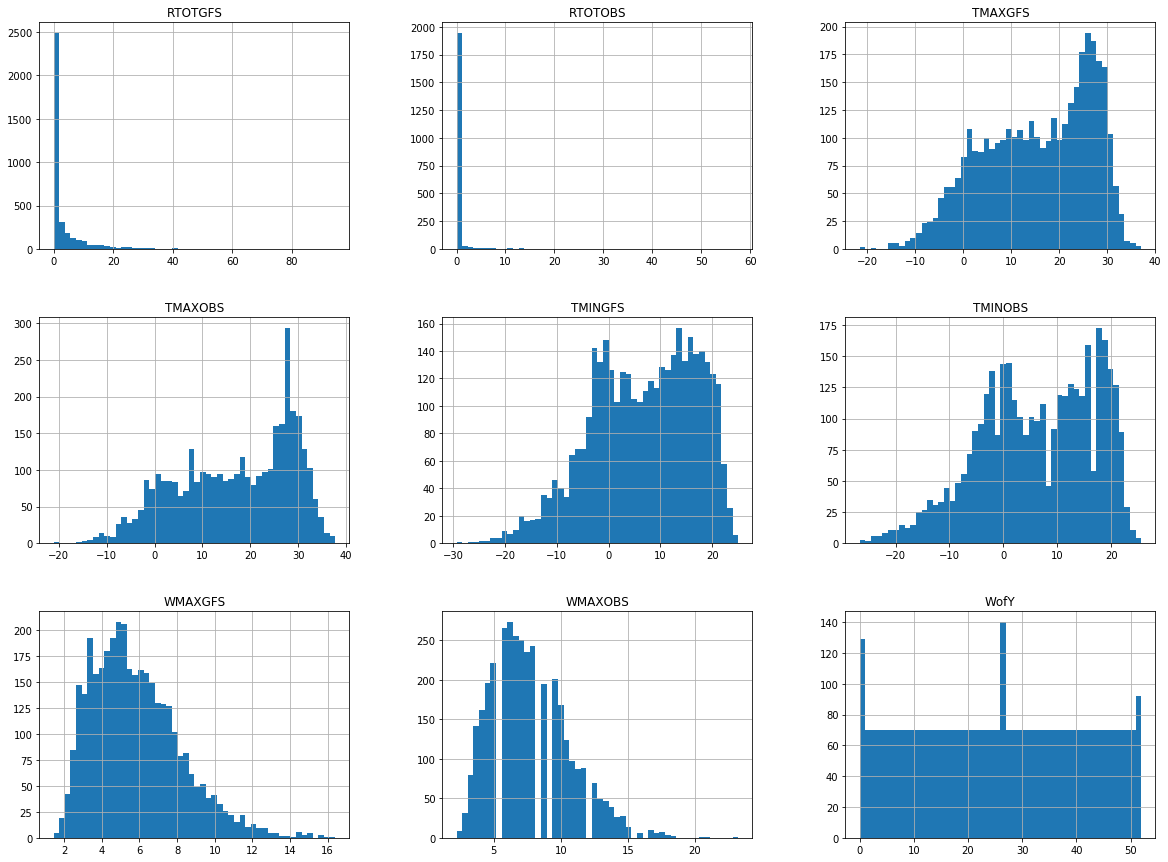

In [20]:
all_daily_data.hist(bins=50, figsize=(20, 15))
plt.show()

### Preprocessing
#### Drop NaN rows

In [47]:
all_daily_data.set_index(pd.to_datetime(all_daily_data.index).date, inplace=True)
all_3hr_data.set_index(pd.to_datetime(all_3hr_data.index).date, inplace=True)
all_data = pd.concat([all_daily_data, all_3hr_data.groupby(all_3hr_data.index).mean()], 
                     axis=1)
all_data.describe()

,TMAXOBS,TMINOBS,WMAXOBS,RTOTOBS,TMAXGFS,TMINGFS,WMAXGFS,RTOTGFS,WofY,DWPC,...,UWND700,UWND500,UWND250,UWND100,VWND925,VWND850,VWND700,VWND500,VWND250,VWND100
count,3626.000000,3626.000000,3628.000000,2040.000000,3613.000000,3613.000000,3613.000000,3613.000000,3651.000000,3628.000000,...,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000
mean,16.926672,6.138230,7.672654,0.448922,15.552151,6.688519,5.833282,3.275851,25.736511,6.789375,...,19.365362,30.836949,51.637853,32.762221,2.405293,0.571284,-1.809407,-2.957140,-1.111248,-1.256594
std,11.939826,10.723779,2.941521,2.894789,11.237922,10.016658,2.363949,7.164487,15.061541,10.919402,...,13.905752,20.539691,31.760164,19.812013,13.027114,12.430945,13.998946,19.529614,30.775787,12.736670
min,-21.111111,-26.666667,2.235136,0.000000,-21.660000,-29.360000,1.431782,0.000000,0.000000,-29.150000,...,-33.222578,-41.337419,-43.756546,-23.111137,-40.752567,-45.811223,-52.605270,-79.356966,-113.476749,-64.988212
25%,7.222222,-1.666667,5.811354,0.000000,6.640000,-0.960000,4.045986,0.000000,13.000000,-1.406094,...,9.517211,15.973054,28.305504,17.751041,-7.006174,-7.849683,-10.780356,-14.830654,-20.169407,-9.087892
50%,18.888889,6.666667,7.152436,0.000000,17.140000,7.540000,5.456189,0.270000,26.000000,7.491250,...,19.520066,29.395053,48.742207,30.708671,1.620068,-0.233848,-2.538497,-3.167218,-2.514362,-1.919623
75%,27.777778,15.555556,9.387573,0.000000,25.540000,15.140000,7.244308,3.120000,39.000000,16.391094,...,28.885405,44.141255,72.611700,45.453829,10.885838,8.370637,7.074893,7.962542,16.271117,6.180407
max,37.777778,25.555556,23.245418,57.600000,37.140000,25.040000,16.413714,94.690000,52.000000,26.228750,...,58.992637,100.313417,181.545673,120.537188,44.476622,56.749685,59.524774,79.055874,120.758065,58.098403


In [49]:
incomplete_all = all_data[all_data.isnull().any(axis=1)]
incomplete_all_num = [len(incomplete_all[incomplete_all[m].isnull()]) for m in list(incomplete_all)]
display(set(zip(list(incomplete_all), incomplete_all_num)))

{('DWPC', 23),
 ('DWPC100', 2948),
 ('DWPC250', 27),
 ('DWPC500', 23),
 ('DWPC700', 23),
 ('DWPC850', 23),
 ('DWPC925', 23),
 ('HCLD', 23),
 ('HGHT100', 23),
 ('HGHT250', 23),
 ('HGHT500', 23),
 ('HGHT700', 23),
 ('HGHT850', 23),
 ('HGHT925', 23),
 ('LCLD', 23),
 ('MCLD', 23),
 ('PRCP', 23),
 ('PRES', 23),
 ('RTOTGFS', 38),
 ('RTOTOBS', 1611),
 ('TMAXGFS', 38),
 ('TMAXOBS', 25),
 ('TMINGFS', 38),
 ('TMINOBS', 25),
 ('TMPC', 23),
 ('TMPC100', 23),
 ('TMPC250', 23),
 ('TMPC500', 23),
 ('TMPC700', 23),
 ('TMPC850', 23),
 ('TMPC925', 23),
 ('UWND', 23),
 ('UWND100', 23),
 ('UWND250', 23),
 ('UWND500', 23),
 ('UWND700', 23),
 ('UWND850', 23),
 ('UWND925', 23),
 ('VWND', 23),
 ('VWND100', 23),
 ('VWND250', 23),
 ('VWND500', 23),
 ('VWND700', 23),
 ('VWND850', 23),
 ('VWND925', 23),
 ('WMAXGFS', 38),
 ('WMAXOBS', 23),
 ('WSPD', 23),
 ('WofY', 0)}

In [60]:
all_data = all_data[~all_data["RTOTGFS"].isnull()]
all_data = all_data[~all_data["TMAXOBS"].isnull()]
all_data = all_data[~all_data["WMAXOBS"].isnull()]
all_data = all_data[~all_data["DWPC"].isnull()]
all_data = all_data.fillna(value={"DWPC250":all_data["DWPC250"].mean()})
display(all_data.describe())

preci_data = all_data[~all_data["RTOTOBS"].isnull()]

,TMAXOBS,TMINOBS,WMAXOBS,RTOTOBS,TMAXGFS,TMINGFS,WMAXGFS,RTOTGFS,WofY,DWPC,...,UWND700,UWND500,UWND250,UWND100,VWND925,VWND850,VWND700,VWND500,VWND250,VWND100
count,3574.000000,3574.000000,3574.000000,2000.000000,3574.000000,3574.000000,3574.000000,3574.000000,3574.000000,3574.000000,...,3574.000000,3574.000000,3574.000000,3574.000000,3574.000000,3574.000000,3574.000000,3574.000000,3574.000000,3574.000000
mean,16.838121,6.054219,7.672259,0.451600,15.531130,6.675003,5.839378,3.265873,25.668439,6.765035,...,19.422678,30.929917,51.738317,32.821850,2.373387,0.527574,-1.862660,-3.024556,-1.199349,-1.283407
std,11.960306,10.738153,2.936465,2.913847,11.256781,10.030052,2.365587,7.154675,15.114083,10.948790,...,13.908707,20.592102,31.791157,19.857459,13.040375,12.438325,13.980727,19.468709,30.667016,12.751041
min,-21.111111,-26.666667,2.235136,0.000000,-21.660000,-29.360000,1.431782,0.000000,0.000000,-29.150000,...,-33.222578,-41.337419,-43.756546,-23.111137,-40.752567,-45.811223,-52.605270,-79.356966,-113.476749,-64.988212
25%,7.222222,-1.666667,5.811354,0.000000,6.565000,-0.960000,4.049691,0.000000,12.250000,-1.461094,...,9.569834,16.034322,28.456884,17.744137,-7.012119,-7.892919,-10.806313,-14.905280,-20.170887,-9.133535
50%,18.888889,6.666667,7.152436,0.000000,17.040000,7.540000,5.457105,0.270000,26.000000,7.464688,...,19.547713,29.475195,48.880767,30.750088,1.579207,-0.287684,-2.564213,-3.176498,-2.550114,-1.943386
75%,27.222222,15.555556,9.387573,0.000000,25.540000,15.240000,7.244826,3.102500,39.000000,16.439219,...,28.926133,44.412472,72.763731,45.622302,10.867357,8.360120,7.071061,7.925691,16.263639,6.184507
max,37.777778,25.555556,23.245418,57.600000,37.140000,25.040000,16.413714,94.690000,52.000000,26.228750,...,58.992637,100.313417,181.545673,120.537188,44.476622,56.749685,59.524774,79.055874,117.017726,58.098403


In [210]:
all_data['RTOTOBS'].mean()

0.4516

In [ ]:
all_data = all_data.fillna(value={"RTOTOBS":all_data["RTOTOBS"].mean()})


In [56]:
incomplete_all = all_data[all_data.isnull().any(axis=1)]
incomplete_all_num = [len(incomplete_all[incomplete_all[m].isnull()]) for m in list(incomplete_all)]
display(set(zip(list(incomplete_all), incomplete_all_num)))

{('DWPC', 0),
 ('DWPC100', 2894),
 ('DWPC250', 0),
 ('DWPC500', 0),
 ('DWPC700', 0),
 ('DWPC850', 0),
 ('DWPC925', 0),
 ('HCLD', 0),
 ('HGHT100', 0),
 ('HGHT250', 0),
 ('HGHT500', 0),
 ('HGHT700', 0),
 ('HGHT850', 0),
 ('HGHT925', 0),
 ('LCLD', 0),
 ('MCLD', 0),
 ('PRCP', 0),
 ('PRES', 0),
 ('RTOTGFS', 0),
 ('RTOTOBS', 1574),
 ('TMAXGFS', 0),
 ('TMAXOBS', 0),
 ('TMINGFS', 0),
 ('TMINOBS', 0),
 ('TMPC', 0),
 ('TMPC100', 0),
 ('TMPC250', 0),
 ('TMPC500', 0),
 ('TMPC700', 0),
 ('TMPC850', 0),
 ('TMPC925', 0),
 ('UWND', 0),
 ('UWND100', 0),
 ('UWND250', 0),
 ('UWND500', 0),
 ('UWND700', 0),
 ('UWND850', 0),
 ('UWND925', 0),
 ('VWND', 0),
 ('VWND100', 0),
 ('VWND250', 0),
 ('VWND500', 0),
 ('VWND700', 0),
 ('VWND850', 0),
 ('VWND925', 0),
 ('WMAXGFS', 0),
 ('WMAXOBS', 0),
 ('WSPD', 0),
 ('WofY', 0)}

In [57]:
all_data.tail()

,TMAXOBS,TMINOBS,WMAXOBS,RTOTOBS,TMAXGFS,TMINGFS,WMAXGFS,RTOTGFS,WofY,DWPC,...,UWND700,UWND500,UWND250,UWND100,VWND925,VWND850,VWND700,VWND500,VWND250,VWND100
2019-12-27,6.111111,0.000000,6.705409,0.0,11.84,3.84,4.301163,0.00,51,4.827500,...,31.144450,49.433944,82.987136,57.518451,0.350234,4.158461,7.924520,17.033406,49.173175,21.038691
2019-12-28,13.333333,0.000000,10.281627,0.0,13.94,3.54,8.819297,2.73,51,4.350000,...,19.815375,36.290925,87.640967,42.578701,16.559694,17.429951,19.916068,14.367853,24.061481,8.943232
2019-12-29,15.000000,5.000000,10.281627,NaN,15.94,9.34,9.701546,11.58,51,12.056875,...,27.977477,32.257952,84.904880,27.246260,28.456817,31.540922,37.370745,50.560089,74.577693,11.951971
2019-12-30,3.333333,-0.555556,11.622709,NaN,7.24,-1.66,11.111256,2.57,52,0.690625,...,25.717089,34.467597,56.571580,27.536655,13.981834,13.542084,17.249965,36.847703,53.355025,15.255425
2019-12-31,0.555556,-1.111111,12.963791,0.0,-0.36,-2.26,8.769265,0.04,52,-5.313750,...,40.194860,43.550657,65.518598,43.044214,2.164162,-8.973858,-10.856907,-9.170278,5.966609,13.061975


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ABE8770848>,
      dtype=object)

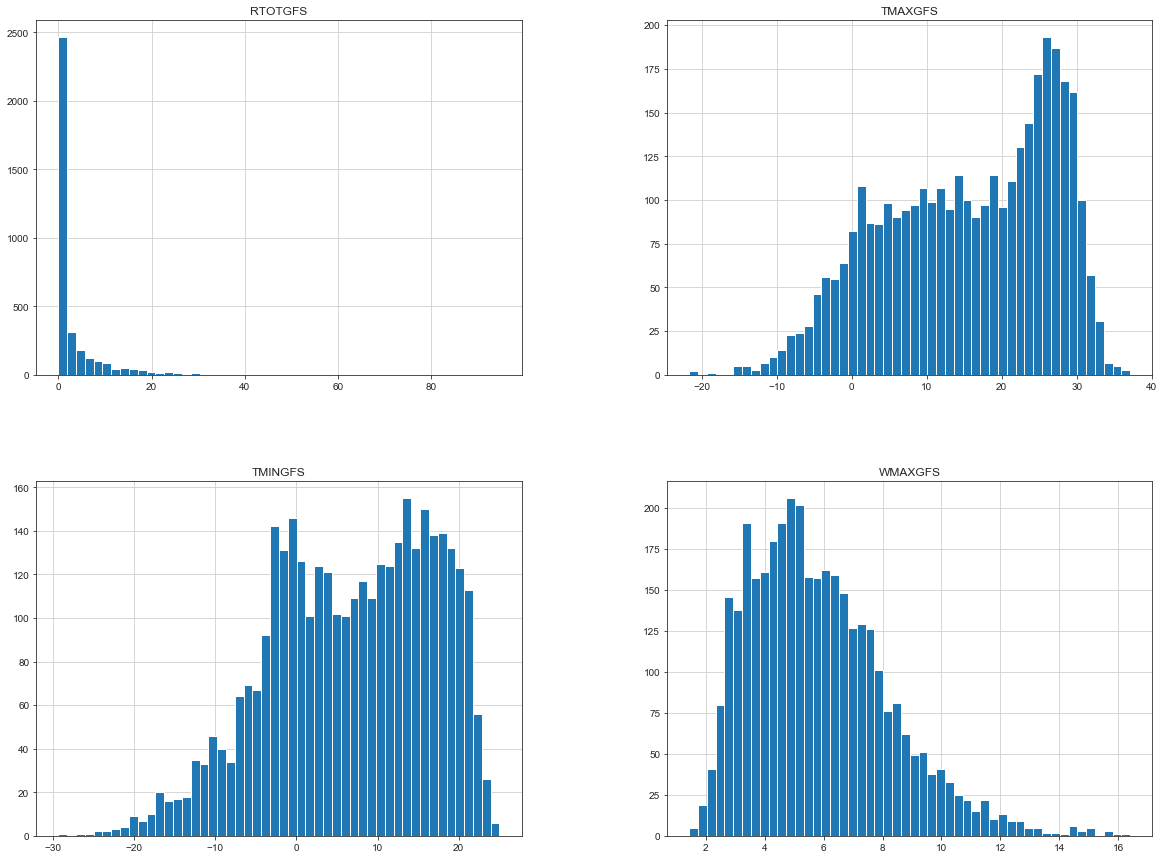

In [175]:
all_data[['TMAXGFS','TMINGFS','WMAXGFS','RTOTGFS']].hist(bins=50, figsize=(20, 15))

## Prediction via regression

In [123]:
predictors = ['TMAXGFS','TMINGFS','WMAXGFS','RTOTGFS','DWPC','HCLD','LCLD','MCLD','PRCP','PRES','TMPC','UWND','VWND','WSPD','DWPC925','DWPC850','DWPC700','DWPC500','DWPC250','HGHT925','HGHT850','HGHT700','HGHT500','HGHT250','HGHT100','TMPC925','TMPC850','TMPC700','TMPC500','TMPC250','TMPC100','UWND925','UWND850','UWND700','UWND500','UWND250','UWND100','VWND925','VWND850','VWND700','VWND500','VWND250','VWND100']
train_enddate0 = pd.to_datetime('2018-12-29').date()
train_startdate = pd.to_datetime('2010-1-3').date()
train_enddate1 = pd.to_datetime('2018-12-30').date()
train_enddate3 = pd.to_datetime('2018-12-28').date()
test_startdate = pd.to_datetime('2019-1-1').date()
test_enddate = pd.to_datetime('2019-12-30').date()
test_startdate0 = pd.to_datetime('2019-1-2').date()
test_enddate0 = pd.to_datetime('2019-12-31').date()
test_startdate1 = pd.to_datetime('2019-1-3').date()
test_enddate1 = pd.to_datetime('2019-12-27').date()
test_startdate2 = pd.to_datetime('2019-1-4').date()
test_enddate2 = pd.to_datetime('2019-12-28').date()
date1 = pd.to_datetime('2019-01-01').date()
display(preci_data[['RTOTOBS']].loc[train_startdate:train_enddate1])

,RTOTOBS
2010-01-03,0.0
2010-01-04,0.0
2010-01-06,0.0
2010-01-09,0.0
2010-01-10,0.0
...,...
2018-12-22,0.0
2018-12-23,0.0
2018-12-24,0.0
2018-12-26,0.0


In [203]:
# Define function to apply regression to input dataframes
def reg_predict(x, y, predict):
    model = ElasticNet(fit_intercept = True, normalize = True, l1_ratio=0.1)  
    model.fit(x, y)
    train, predict = model.predict(x), model.predict(predict)
    return train, predict

In [204]:
# Get predicted values using training data (_predict) and predicted values for 2019 (_predict19) 
# 2019 predictions will be compared to 2019 observations
Tmax_predict, Tmax_predict19     = reg_predict(all_data[predictors].loc[:train_enddate0], 
                                               all_data[['TMAXOBS']].loc[train_startdate:train_enddate1], all_data[predictors].loc[test_startdate:test_enddate])
Tmin_predict, Tmin_predict19     = reg_predict(all_data[predictors].loc[:train_enddate0],
                                               all_data[['TMINOBS']].loc[train_startdate:train_enddate1], all_data[predictors].loc[test_startdate:test_enddate])
Wmax_predict, Wmax_predict19     = reg_predict(all_data[predictors].loc[:train_enddate0],
                                               all_data[['WMAXOBS']].loc[train_startdate:train_enddate1], all_data[predictors].loc[test_startdate:test_enddate])
Precip_predict, Precip_predict19 = reg_predict(preci_data[predictors].loc[:train_enddate3],
                                               preci_data[['RTOTOBS']].loc[train_startdate:train_enddate1], preci_data[predictors].loc[test_startdate1:test_enddate1])

In [205]:
preci_data[predictors].loc[test_startdate2:test_enddate2]

,TMAXGFS,TMINGFS,WMAXGFS,RTOTGFS,DWPC,HCLD,LCLD,MCLD,PRCP,PRES,...,UWND700,UWND500,UWND250,UWND100,VWND925,VWND850,VWND700,VWND500,VWND250,VWND100
2019-01-04,5.24,-0.06,3.667424,0.00,-3.830625,64.6250,0.0000,28.8750,0.00000,985.00625,...,4.140064,2.398508,26.241623,36.337124,-0.563486,-3.367061,-1.115635,-1.809327,17.479634,2.377327
2019-01-05,9.54,0.64,4.701064,0.00,-0.427500,13.6875,0.0000,9.3750,0.00000,983.80625,...,18.322906,27.290482,37.759114,35.087321,-12.871279,-18.418572,-21.954105,-26.508026,-40.402543,-15.223189
2019-01-06,7.54,1.64,7.029225,0.09,1.695000,38.6875,0.0000,24.0000,0.00000,992.16250,...,28.284438,52.220519,87.964830,48.247646,-0.179670,-1.576521,-5.100893,-15.322062,-71.437108,-24.855068
2019-01-08,7.94,0.04,11.131936,0.04,3.128750,5.3750,14.7500,13.3125,0.10750,984.15625,...,42.407221,86.826858,117.213575,45.868662,-3.479578,-5.372271,-1.410658,-7.498485,3.277051,3.554308
2019-01-09,-0.36,-5.96,8.514693,0.00,-10.110000,0.0000,2.1250,0.0000,0.00000,995.16250,...,40.059613,77.577713,95.276966,50.261203,-20.878595,-30.199227,-34.665362,-63.620583,-63.114875,-32.402333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,10.34,2.34,4.850773,0.00,1.661250,51.7500,0.0000,0.0000,0.00000,991.23750,...,19.118397,30.302769,64.404638,40.688598,8.761952,6.139219,3.153008,-8.192690,-27.724719,-14.624186
2019-12-25,13.24,4.54,5.793962,0.00,4.661875,69.6250,0.0000,0.0000,0.00000,987.18125,...,26.725630,43.741481,77.852000,46.690421,20.484462,15.086618,17.636331,24.080183,17.639827,1.969522
2019-12-26,15.34,10.54,6.092618,0.33,10.347500,74.1875,59.5625,10.7500,0.00375,987.30000,...,32.086861,48.779227,71.785920,52.083513,21.290227,15.606315,21.901472,22.754361,30.969880,12.378108
2019-12-27,11.84,3.84,4.301163,0.00,4.827500,87.1250,52.8750,0.1250,0.03250,993.08750,...,31.144450,49.433944,82.987136,57.518451,0.350234,4.158461,7.924520,17.033406,49.173175,21.038691


In [206]:
from sklearn.metrics import mean_squared_error as mse
Tmax_train_error = mse(Tmax_predict, all_data[['TMAXOBS']].loc[train_startdate:train_enddate1])
Tmax_test_error = mse(Tmax_predict19, all_data[['TMAXOBS']].loc[test_startdate0:test_enddate0])
display(np.sqrt(Tmax_train_error), np.sqrt(Tmax_test_error))

11.934226490253982

11.867334770059596

In [207]:
Tmin_train_error = mse(Tmin_predict, all_data[['TMINOBS']].loc[train_startdate:train_enddate1])
Tmin_test_error = mse(Tmin_predict19, all_data[['TMINOBS']].loc[test_startdate0:test_enddate0])
display(np.sqrt(Tmin_train_error), np.sqrt(Tmin_test_error))

10.699626186433575

10.821406477997376

In [208]:
Wmax_train_error = mse(Wmax_predict, all_data[['WMAXOBS']].loc[train_startdate:train_enddate1])
Wmax_test_error = mse(Wmax_predict19, all_data[['WMAXOBS']].loc[test_startdate0:test_enddate0])
display(np.sqrt(Wmax_train_error), np.sqrt(Wmax_test_error))

2.9284635071623217

3.009254152625143

In [209]:
Precip_train_error = mse(Precip_predict, preci_data[['RTOTOBS']].loc[train_startdate:train_enddate1])
Precip_test_error = mse(Precip_predict19, preci_data[['RTOTOBS']].loc[test_startdate2:test_enddate2])
display(np.sqrt(Precip_train_error), np.sqrt(Precip_test_error))

3.0186431981993946

1.6009784236657307

In [138]:
%matplotlib inline
sns.set_style('ticks')

# Define function to plot actual vs. predicted values
def plot_predict(time, actual, predicted, colors, legendloc, title, ylabel, ymin, ymax):

    plt.figure(figsize=(15,5))
    plt.plot(time, actual, color = colors[0], label = 'Observed')
    plt.plot(time, predicted, color = colors[1], alpha = 0.8, label = 'Predicted')
    # Add dashed vertical line to denote beginning of 2019
    plt.vlines(dt.datetime(2019, 1, 1), ymin, ymax, linestyles = 'dashed', alpha = 0.7)
    plt.legend(loc = legendloc)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Time')
    plt.xlim(time[0]-pd.Timedelta(days=1),  time[-1]+pd.Timedelta(days=1))
    plt.ylim(ymin, ymax)
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (3574,) and (3572,)

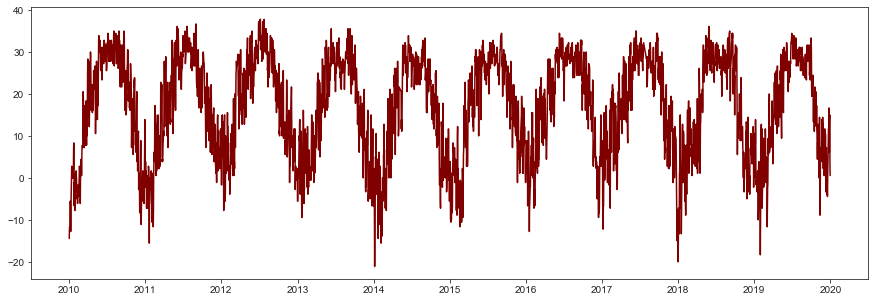

In [139]:
# Plot predicted vs. actual Tmax
Tmax_actual    = all_data['TMAXOBS']
Tmax_predicted = np.concatenate((Tmax_predict, Tmax_predict19))
colors = ['maroon', 'red']
plot_predict(pd.to_datetime(all_data.index), Tmax_actual, Tmax_predicted, colors, legendloc = 'lower left', 
             title = 'Daily Maximum Temperature', ylabel = 'Temperature (deg C)', 
             ymin = -25, ymax = 45)

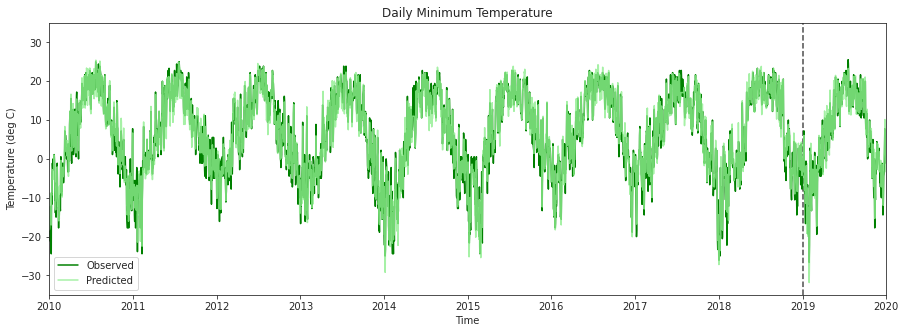

In [74]:
# Plot predicted vs. actual Tmin
Tmin_actual    = all_daily_data['TMINOBS']
Tmin_predicted = np.concatenate((Tmin_predict, Tmin_predict19))
colors = ['green', 'lightgreen']
plot_predict(pd.to_datetime(all_daily_data.index), Tmin_actual, Tmin_predicted, colors, legendloc = 'lower left', 
             title = 'Daily Minimum Temperature', ylabel = 'Temperature (deg C)', 
             ymin = -35, ymax = 35)

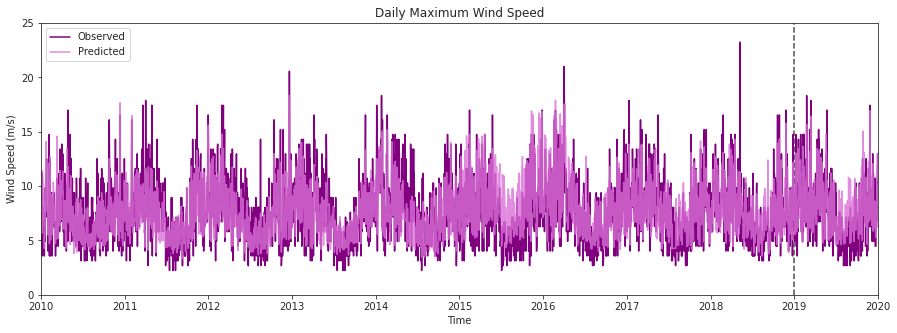

In [75]:
# Plot predicted vs. actual Wmax
Wmax_actual    = all_daily_data['WMAXOBS']
Wmax_predicted = np.concatenate((Wmax_predict, Wmax_predict19))
colors = ['purple', 'orchid']
plot_predict(pd.to_datetime(all_daily_data.index), Wmax_actual, Wmax_predicted, colors, legendloc = 'upper left', 
             title = 'Daily Maximum Wind Speed', ylabel = 'Wind Speed (m/s)', 
             ymin = 0, ymax = 25)

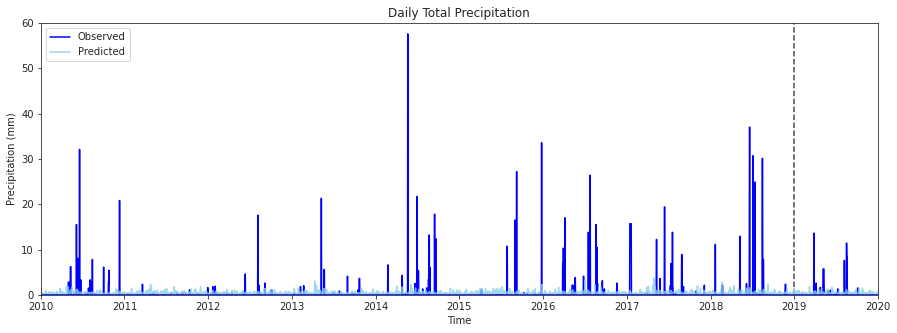

In [76]:
# Plot predicted vs. actual Precip
Precip_actual    = all_daily_data['RTOTOBS']
Precip_predicted = np.concatenate((Precip_predict, Precip_predict19))
colors = ['blue', 'skyblue']
plot_predict(pd.to_datetime(all_daily_data.index), Precip_actual, Precip_predicted, colors, legendloc = 'upper left', 
             title = 'Daily Total Precipitation', ylabel = 'Precipitation (mm)', 
             ymin = 0, ymax = 60)

In [0]:
# Define function to compute MSE for all predicted variables
def calc_mse(Tmax_actual, Tmax_predicted, Tmin_actual, Tmin_predicted,
              Wmax_actual, Wmax_predicted, Precip_actual, Precip_predicted):

    # Calculate MSE for each variable using sklearn function
    Tmax_mse   = mean_squared_error(Tmax_actual, Tmax_predicted)
    Tmin_mse   = mean_squared_error(Tmin_actual, Tmin_predicted)
    Wmax_mse   = mean_squared_error(Wmax_actual, Wmax_predicted)
    Precip_mse = mean_squared_error(Precip_actual, Precip_predicted)

    # Total MSE
    total_mse  = Tmax_mse + Tmin_mse + Wmax_mse + Precip_mse

    # Print to user
    print('Tmax error: {0:4.3f}'.format(Tmax_mse))
    print('Tmin error: {0:4.3f}'.format(Tmin_mse)) 
    print('Wmax error: {0:4.3f}'.format(Wmax_mse))
    print('Precip error: {0:4.3f}'.format(Precip_mse))
    print('Total error: {0:4.3f}'.format(total_mse))

In [78]:
calc_mse(Tmax_actual, Tmax_predicted, Tmin_actual, Tmin_predicted,
         Wmax_actual, Wmax_predicted, Precip_actual, Precip_predicted)

Tmax error: 5.222
Tmin error: 4.186
Wmax error: 2.928
Precip error: 6.594
Total error: 18.929
